# Interna

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from wordcloud import WordCloud
from matplotlib_venn import venn2

In [2]:
DATASET = {
  'main': 'datasets/HIV.csv',
  'reference': 'datasets/reference.csv',
  'smiles': 'datasets/smiles.csv',
  'names': 'datasets/smiles.csv'
}

## Load dataset

In [3]:
main_df = pd.read_csv(DATASET['main'], encoding='unicode_escape')
main_df['HIV_active'] = main_df['HIV_active'] == 1

smiles_df = pd.read_csv(DATASET['smiles'])
ref_df = pd.read_csv(DATASET['reference'])
ref_df = ref_df.join(smiles_df.set_index('NSC'), on='NSC')
ref_df = ref_df.rename(columns={'SMILES': 'smiles', 'Conclusion': 'activity'})
ref_df['HIV_active'] = ref_df['activity'].isin(('CM', 'CA'))
ref_df.pop('NSC')
pass

In [4]:
main_df.head()

,smiles,activity,HIV_active
0,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,False
1,C(=Cc1ccccc1)C1=[O+][Cu-3]2([O+]=C(C=Cc3ccccc3...,CI,False
2,CC(=O)N1c2ccccc2Sc2c1ccc1ccccc21,CI,False
3,Nc1ccc(C=Cc2ccc(N)cc2S(=O)(=O)O)c(S(=O)(=O)O)c1,CI,False
4,O=S(=O)(O)CCS(=O)(=O)O,CI,False


In [5]:
ref_df.head()

,activity,smiles,HIV_active
0,CI,CCC1=[O][Cu+2]2([O]=C(CC)CC(=[O]2)CC)[O]=C(CC)C1,False
1,CI,C1C(=[O][Cu]2([O]=C(CC(=[O]2)c3ccccc3)\C=C\c4c...,False
2,CI,CC(=O)N1c2ccccc2Sc3c1ccc4ccccc34,False
3,CI,Nc1ccc(\C=C\c2ccc(N)cc2S(=O)(=O)O)c(c1)S(=O)(=O)O,False
4,CI,[Na+].OS(=O)(=O)CCS(=O)(=O)O,False


## Inspect main dataset

### Remove duplicate values

In [6]:
main_df.describe()

,smiles,activity,HIV_active
count,41913,41913,41913
unique,41127,3,2
top,CCCc1cc(=O)oc2c3c(c4c(c12)OC(C)(C)CC4)OC(C)C(C...,CI,False
freq,7,40426,40426


In [7]:
print('drop', sum(main_df.duplicated()), 'duplicated rows')
main_df = main_df.drop_duplicates()
main_df.describe()

drop 749 duplicated rows


,smiles,activity,HIV_active
count,41164,41164,41164
unique,41127,3,2
top,CCCc1cc(=O)oc2c3c(c4c(c12)OC(C)(C)C=C4)OC(C)C(...,CI,False
freq,3,39697,39697


duplicated smiles: 36


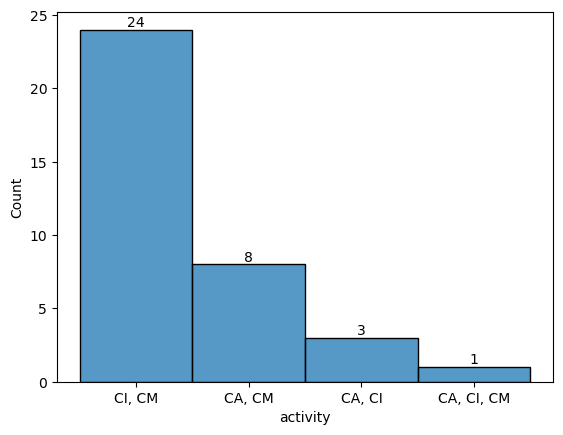

In [8]:
count = main_df['smiles'].value_counts()
print('duplicated smiles:', sum(count > 1))
smiles_grouped = main_df[main_df['smiles'].isin(count.index[count > 1])].groupby('smiles').agg({
    'activity': lambda x: ', '.join(sorted(x)),
    'HIV_active': 'sum'
  }).reset_index()
ax = sns.histplot(smiles_grouped['activity'])
ax.bar_label(ax.containers[0])
plt.show()

In [9]:
for _, row in smiles_grouped.iterrows():
  smiles, activity = row['smiles'], row['activity']
  rep_act, rep_active = ('CM', True) if activity == 'CA, CM' else ('CI', False)
  main_df.loc[main_df['smiles'] == smiles, 'activity'] = rep_act
  main_df.loc[main_df['smiles'] == smiles, 'HIV_active'] = rep_active

main_df = main_df.drop_duplicates()
main_df.describe()

,smiles,activity,HIV_active
count,41127,41127,41127
unique,41127,3,2
top,CCC1=[O+][Cu-3]2([O+]=C(CC)C1)[O+]=C(CC)CC(CC)...,CI,False
freq,1,39697,39697


### Data distribution

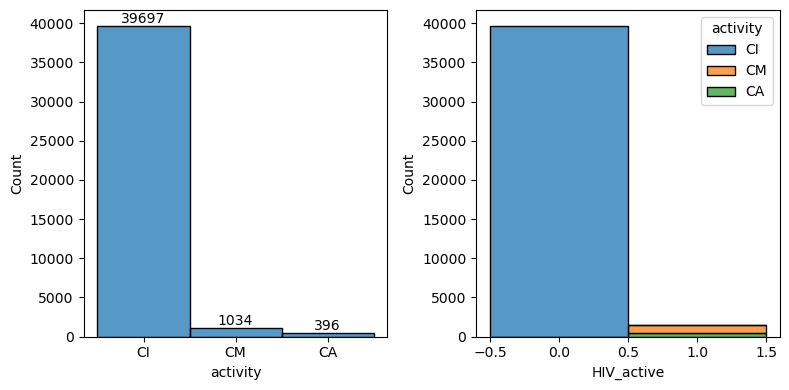

active:inactive ratio is 1:27.76


In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

axx = sns.histplot(main_df['activity'], ax=ax1)
axx.bar_label(axx.containers[0])

sns.histplot(main_df, discrete=True, ax=ax2, x='HIV_active', hue='activity', multiple='stack')

fig.tight_layout()
plt.show()

print(f'active:inactive ratio is 1:{sum(~main_df['HIV_active'])/sum(main_df['HIV_active']):.2f}')

### Atom count distribution

[02:09:51] WARNING: not removing hydrogen atom without neighbors
[02:09:51] WARNING: not removing hydrogen atom without neighbors


All data 25.510321686483334 12.112791750089489


[02:09:55] WARNING: not removing hydrogen atom without neighbors
[02:09:55] WARNING: not removing hydrogen atom without neighbors


HIV inactive 25.19671511701136 11.583380292630888
HIV active 34.21608391608392 20.41405253707982


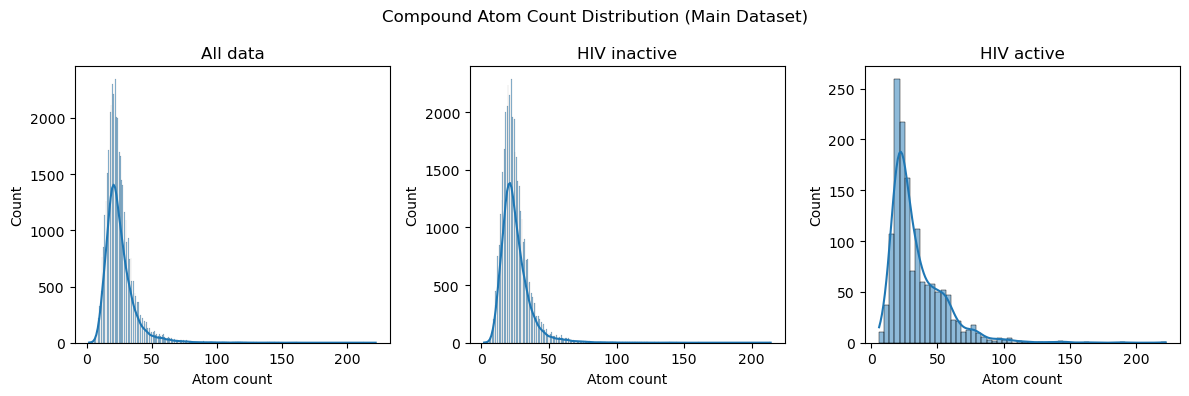

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
atom_count = [
  (main_df['smiles'], 'All data'),
  (main_df[~main_df['HIV_active']]['smiles'], 'HIV inactive'),
  (main_df[main_df['HIV_active']]['smiles'], 'HIV active')
]

for (ax, (df, title)) in zip(ax, atom_count):
  acount = df.apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
  plot = sns.histplot(acount, kde=True, ax=ax)
  plot.set_xlabel('Atom count')
  ax.title.set_text(title)
  print(title, acount.mean(), acount.std())

fig.suptitle('Compound Atom Count Distribution (Main Dataset)')
fig.tight_layout()

### Atom cloud

[02:09:59] WARNING: not removing hydrogen atom without neighbors
[02:09:59] WARNING: not removing hydrogen atom without neighbors


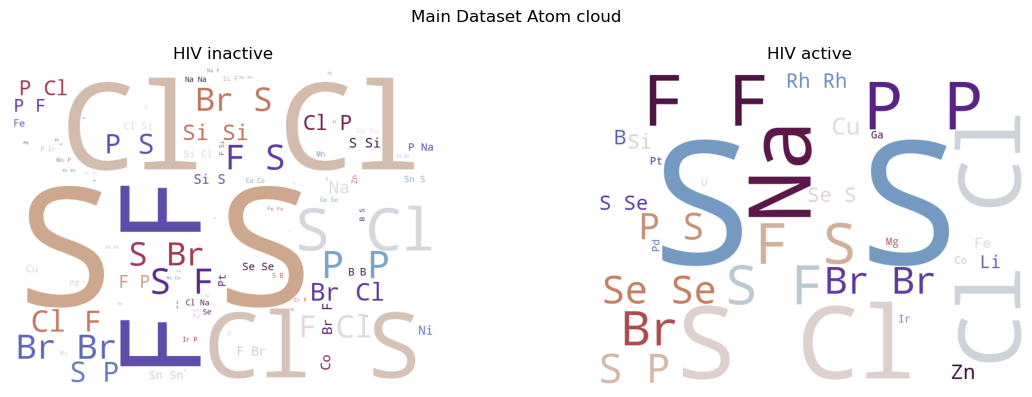

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
atom_sets = []

for (ax, (df, title)) in zip(ax, atom_count[1:]):
  atoms = []
  for mol in df.apply(lambda x: Chem.MolFromSmiles(x).GetAtoms()):
    atoms.extend([atom.GetSymbol() for atom in mol if atom.GetSymbol() not in ('C', 'N', 'O')])
  atom_sets.append(set(atoms))

  wc = WordCloud(background_color='white', colormap='twilight', width = 800, height = 600).generate(' '.join(atoms))
  ax.imshow(wc)
  ax.axis('off')
  ax.title.set_text(title)

fig.suptitle('Main Dataset Atom cloud')
fig.tight_layout()

common atom: 24
exclusive atom: 28
total atom: 52
{'Mn', 'Cs', 'Tl', 'Ag', 'Ho', 'Ac', 'Cr', 'Hg', 'V', 'Au', 'Te', 'Sb', 'Re', 'Bi', 'Ti', 'Pb', 'Ca', 'Ru', 'W', 'Al', 'Sn', 'Ni', 'Gd', 'Mo', 'H', 'Ge', 'Tb', 'Zr'}
{'P', 'I', 'Rh', 'As', 'Ir', 'Co', 'Na', 'Fe', 'S', 'Li', 'Se', 'Cl', 'Ga', 'F', 'Br', 'Cu', 'Si', 'U', 'Pt', 'Mg', 'Zn', 'K', 'Pd', 'B'}


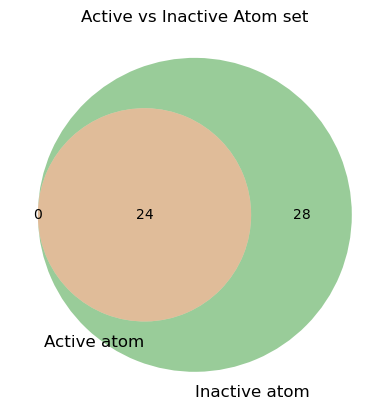

In [13]:
inactive_atom = atom_sets[0]
active_atom = atom_sets[1]

print('common atom:', len(set.intersection(active_atom, inactive_atom)))
print('exclusive atom:', len(set.symmetric_difference(active_atom, inactive_atom)))
print('total atom:', len(set.union(active_atom, inactive_atom)))
print(inactive_atom.difference(active_atom))
print(inactive_atom.intersection(active_atom))

venn2([active_atom, inactive_atom], ('Active atom', 'Inactive atom'))
plt.title('Active vs Inactive Atom set')
plt.show()

## Inspect reference dataset

### Remove duplicated values

In [14]:
ref_df.describe()

,activity,smiles,HIV_active
count,43850,43244,43850
unique,3,42671,2
top,CI,COC1=NC(=C(\N=C\C(OC(=O)C)C(OC(=O)C)C(COC(=O)C...,False
freq,42038,5,42038


In [15]:
print('drop', sum(ref_df.duplicated()), 'duplicated rows')
ref_df = ref_df.drop_duplicates()
ref_df.describe()

drop 1149 duplicated rows


,activity,smiles,HIV_active
count,42701,42698,42701
unique,3,42671,2
top,CI,[Na+].Oc1c(cc(c2cccnc12)S(=O)(=O)O)C(=O)Nc3ccc...,False
freq,41136,2,41136


duplicated smiles: 27


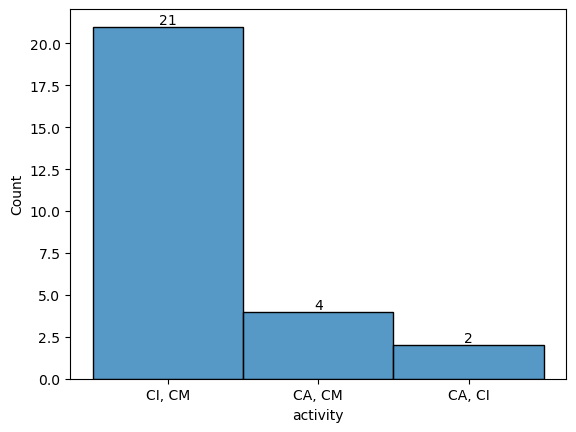

In [16]:
count = ref_df['smiles'].value_counts()
print('duplicated smiles:', sum(count > 1))
smiles_grouped = ref_df[ref_df['smiles'].isin(count.index[count > 1])].groupby('smiles').agg({
    'activity': lambda x: ', '.join(sorted(x)),
    'HIV_active': 'sum'
  }).reset_index()
ax = sns.histplot(smiles_grouped['activity'])
ax.bar_label(ax.containers[0])
plt.show()

In [17]:
for _, row in smiles_grouped.iterrows():
  smiles, activity = row['smiles'], row['activity']
  rep_act, rep_active = ('CM', True) if activity == 'CA, CM' else ('CI', False)
  ref_df.loc[ref_df['smiles'] == smiles, 'activity'] = rep_act
  ref_df.loc[ref_df['smiles'] == smiles, 'HIV_active'] = rep_active

ref_df = ref_df.drop_duplicates()
ref_df.describe()

,activity,smiles,HIV_active
count,42674,42671,42674
unique,3,42671,2
top,CI,CCC1=[O][Cu+2]2([O]=C(CC)CC(=[O]2)CC)[O]=C(CC)C1,False
freq,41136,1,41136


### Detect missing values

In [18]:
print('dropped missing values', ref_df.isna().apply(sum), sep='\n')
ref_df = ref_df.dropna()
ref_df.describe()

dropped missing values
activity      0
smiles        3
HIV_active    0
dtype: int64


,activity,smiles,HIV_active
count,42671,42671,42671
unique,3,42671,2
top,CI,CCC1=[O][Cu+2]2([O]=C(CC)CC(=[O]2)CC)[O]=C(CC)C1,False
freq,41135,1,41135


### Detect invalid compound

In [19]:
invalid_smiles = ref_df['smiles'].apply(Chem.MolFromSmiles).isna()
ref_df = ref_df[~invalid_smiles]
print('dropped', sum(invalid_smiles), 'invalid smiles')

[02:10:03] Explicit valence for atom # 5 Al, 9, is greater than permitted
[02:10:03] SMILES Parse Error: syntax error while parsing: [R]c1ccc2c(c1)C(CC3[C@@](C)(CCCC23C)C(=O)OC)OO
[02:10:03] SMILES Parse Error: Failed parsing SMILES '[R]c1ccc2c(c1)C(CC3[C@@](C)(CCCC23C)C(=O)OC)OO' for input: '[R]c1ccc2c(c1)C(CC3[C@@](C)(CCCC23C)C(=O)OC)OO'
[02:10:03] SMILES Parse Error: syntax error while parsing: O=C1O[Cu+2]2(Nc3ccccc3C(=O)O2)Nc4ccccc14.[RH].[RH]
[02:10:03] SMILES Parse Error: Failed parsing SMILES 'O=C1O[Cu+2]2(Nc3ccccc3C(=O)O2)Nc4ccccc14.[RH].[RH]' for input: 'O=C1O[Cu+2]2(Nc3ccccc3C(=O)O2)Nc4ccccc14.[RH].[RH]'
[02:10:03] SMILES Parse Error: syntax error while parsing: [R]Cc1cc(cc(C(=O)O)c1O)C(O)(c2cc(Cc3cc(cc(C(=O)O)c3O)\C(=C/4\C=CC(=O)C(=C4)C(=O)O)\c5ccc(O)c(c5)C(=O)O)c(O)c(c2)C(=O)O)c6cc(Cc7cc(C(c8ccc(O)c(c8)C(=O)O)c9cc(Cc%10cc(cc(C(=O)O)c%10O)C(O)(c%11ccc(O)c(c%11)C(=O)O)c%12cc([R])c(O)c(c%12)C(=O)O)cc(C(=O)O)c9O)c(O)c(c7)C(=O)O)cc(C(=O)O)c6O
[02:10:03] SMILES Parse Error: Faile

[02:10:03] Explicit valence for atom # 17 B, 7, is greater than permitted
[02:10:03] Explicit valence for atom # 6 B, 4, is greater than permitted
[02:10:03] SMILES Parse Error: syntax error while parsing: [R]N.O=C1NNC(=O)N1
[02:10:03] SMILES Parse Error: Failed parsing SMILES '[R]N.O=C1NNC(=O)N1' for input: '[R]N.O=C1NNC(=O)N1'
[02:10:03] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[02:10:03] Explicit valence for atom # 1 C, 6, is greater than permitted
[02:10:03] Explicit valence for atom # 9 C, 6, is greater than permitted
[02:10:03] SMILES Parse Error: syntax error while parsing: c1cc2[i+]c3cccc4[i+]c(c1)c2c34
[02:10:03] SMILES Parse Error: Failed parsing SMILES 'c1cc2[i+]c3cccc4[i+]c(c1)c2c34' for input: 'c1cc2[i+]c3cccc4[i+]c(c1)c2c34'
[02:10:03] SMILES Parse Error: syntax error while parsing: [R]C.CC1=Nc2ccccc2NC(=O)C1
[02:10:03] SMILES Parse Error: Failed parsing SMILES '[R]C.CC1=Nc2ccccc2NC(=O)C1' for input: '[R]C.CC1=Nc2ccccc2NC(=O)C1'
[02:10:03] Explicit v

dropped 919 invalid smiles


### Data distribution

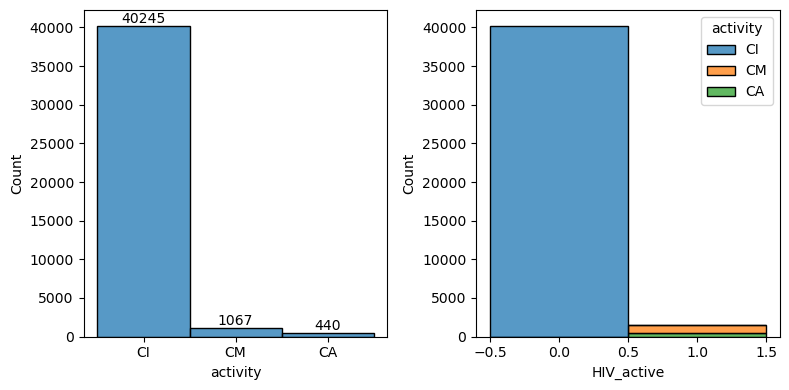

active:inactive ratio is 1:26.71


In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

axx = sns.histplot(ref_df['activity'], ax=ax1)
axx.bar_label(axx.containers[0])

sns.histplot(ref_df, discrete=True, ax=ax2, x='HIV_active', hue='activity', multiple='stack')

fig.tight_layout()
plt.show()

print(f'active:inactive ratio is 1:{sum(~ref_df['HIV_active'])/sum(ref_df['HIV_active']):.2f}')

[02:10:08] WARNING: not removing hydrogen atom without neighbors


All data 25.393274573673118 12.05909303326921


[02:10:12] WARNING: not removing hydrogen atom without neighbors


HIV inactive 25.071586532488507 11.532052753593195
HIV active 33.984074319840744 20.02885729866674


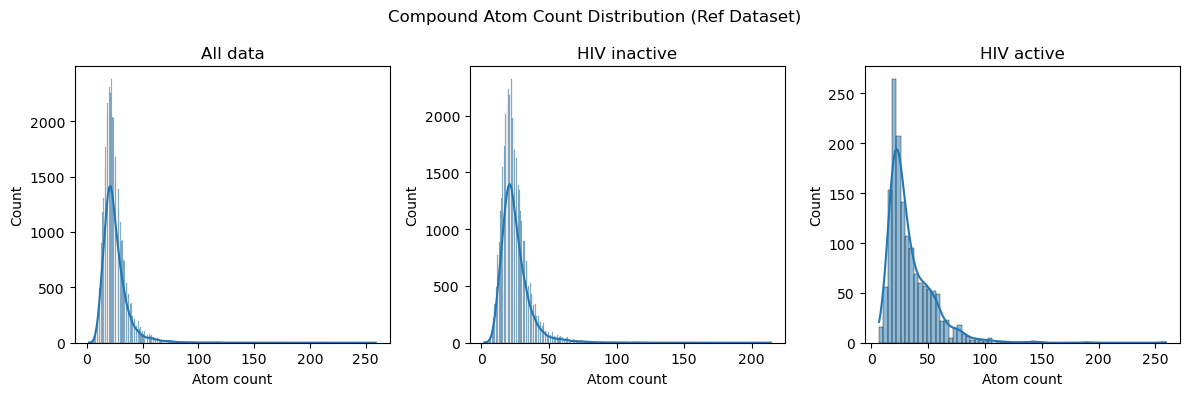

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
atom_count = [
  (ref_df['smiles'], 'All data'),
  (ref_df[~ref_df['HIV_active']]['smiles'], 'HIV inactive'),
  (ref_df[ref_df['HIV_active']]['smiles'], 'HIV active')
]

for (ax, (df, title)) in zip(ax, atom_count):
  acount = df.apply(lambda x: Chem.MolFromSmiles(x).GetNumAtoms())
  plot = sns.histplot(acount, kde=True, ax=ax)
  plot.set_xlabel('Atom count')
  ax.title.set_text(title)
  print(title, acount.mean(), acount.std())

fig.suptitle('Compound Atom Count Distribution (Ref Dataset)')
fig.tight_layout()

[02:10:16] WARNING: not removing hydrogen atom without neighbors


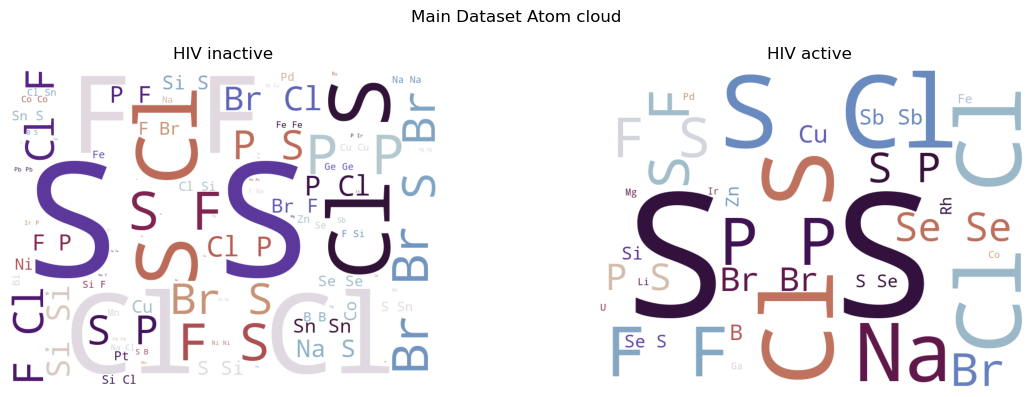

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
atom_sets = []

for (ax, (df, title)) in zip(ax, atom_count[1:]):
  atoms = []
  for mol in df.apply(lambda x: Chem.MolFromSmiles(x).GetAtoms()):
    atoms.extend([atom.GetSymbol() for atom in mol if atom.GetSymbol() not in ('C', 'N', 'O')])
  atom_sets.append(set(atoms))

  wc = WordCloud(background_color='white', colormap='twilight', width = 800, height = 600).generate(' '.join(atoms))
  ax.imshow(wc)
  ax.axis('off')
  ax.title.set_text(title)

fig.suptitle('Main Dataset Atom cloud')
fig.tight_layout()

common atom: 23
exclusive atom: 28
total atom: 51
{'Mn', 'Cs', 'As', 'Ag', 'Ho', 'Ac', 'Cr', 'Ba', 'Hg', 'V', 'Au', 'Te', 'Re', 'Bi', 'Ti', 'Pb', 'Ca', 'Ru', 'W', 'Sn', 'Pt', 'Cd', 'Ni', 'Mo', 'H', 'Tb', 'Ge', 'Zr'}
{'P', 'I', 'Rh', 'Ir', 'Co', 'Na', 'Fe', 'S', 'Li', 'Se', 'Cl', 'Sb', 'Ga', 'F', 'Br', 'Cu', 'Si', 'U', 'Mg', 'Zn', 'K', 'Pd', 'B'}


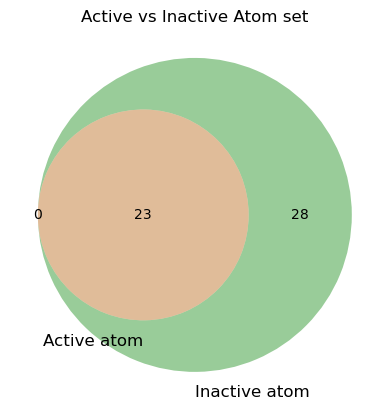

In [23]:
inactive_atom = atom_sets[0]
active_atom = atom_sets[1]

print('common atom:', len(set.intersection(active_atom, inactive_atom)))
print('exclusive atom:', len(set.symmetric_difference(active_atom, inactive_atom)))
print('total atom:', len(set.union(active_atom, inactive_atom)))
print(inactive_atom.difference(active_atom))
print(inactive_atom.intersection(active_atom))

venn2([active_atom, inactive_atom], ('Active atom', 'Inactive atom'))
plt.title('Active vs Inactive Atom set')
plt.show()

## Main Dataset vs Reference Dataset

common compound: 4053
exclusive compound: 74773
total compound: 78826


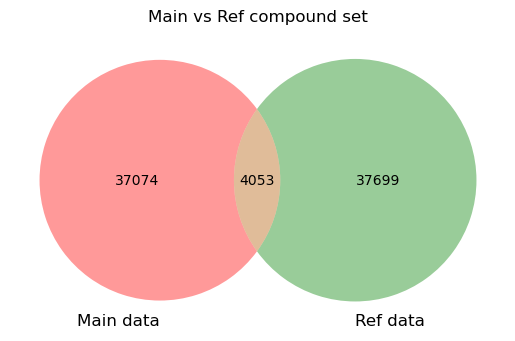

In [24]:
main_set = set(main_df['smiles'])
ref_set = set(ref_df['smiles'])

print('common compound:', len(set.intersection(main_set, ref_set)))
print('exclusive compound:', len(set.symmetric_difference(main_set, ref_set)))
print('total compound:', len(set.union(main_set, ref_set)))

venn2([main_set, ref_set], ('Main data', 'Ref data'))
plt.title('Main vs Ref compound set')
plt.show()

## Visualize smiles

In [36]:
from PIL import Image

def image_grid(imgs, rows, cols):
  assert len(imgs) == rows*cols

  w, h = imgs[0].size
  grid = Image.new('RGB', size=(cols*w, rows*h))
  
  for i, img in enumerate(imgs):
      grid.paste(img, box=(i%cols*w, i//cols*h))
  return grid

In [41]:
from rdkit.Chem import Draw

def get_mol_image(smiles):
  mol = Chem.MolFromSmiles(smiles)
  # print(mol.GetNumAtoms())
  # print(mol.GetAtoms())
  # for atom in mol.GetAtoms():
  #   print(atom.GetSymbol(), end=' ')
  return Draw.MolToImage(mol)

def get_mol_images(smileses):
  images = []
  for smiles in smileses:
    images.append(get_mol_image(smiles))
  return images

In [57]:
SAMPLE_COUNT = 10
ROW = 5
COL = 2
SEED = 976

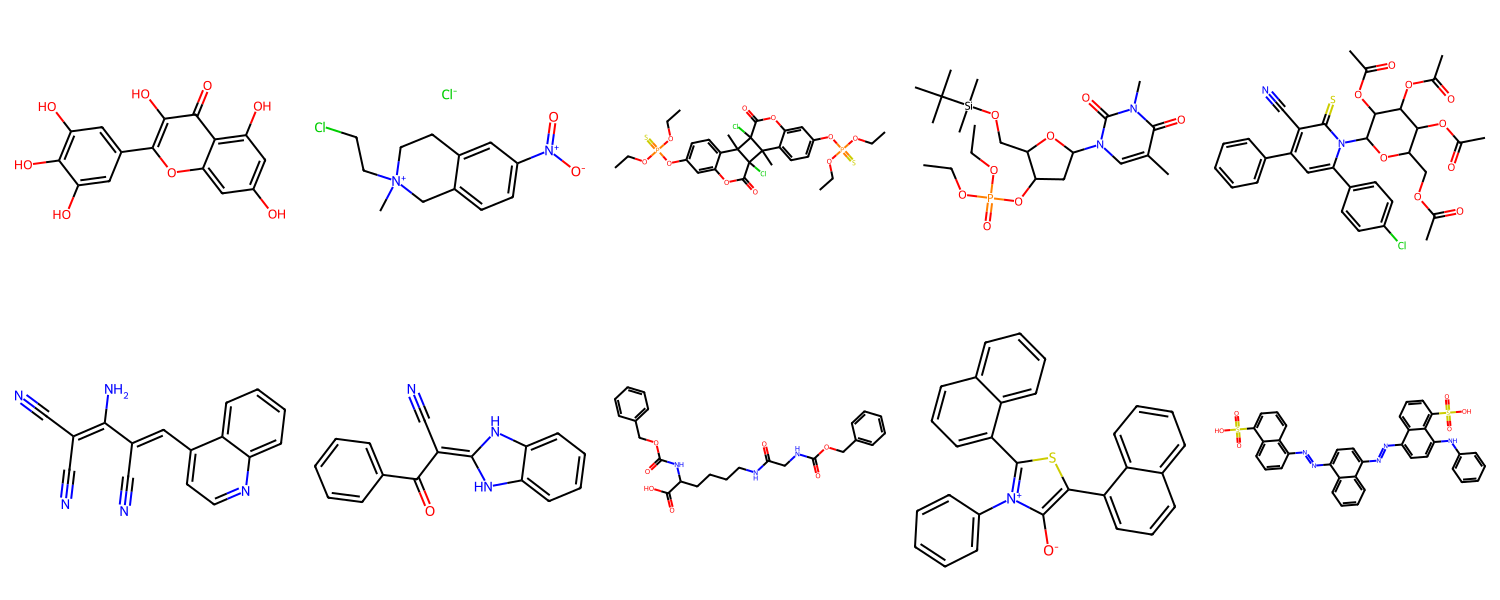

In [58]:
ci_samples = main_df[main_df['activity'] == 'CI'].sample(SAMPLE_COUNT, random_state=SEED)['smiles'].values
image_grid(get_mol_images(ci_samples), COL, ROW)

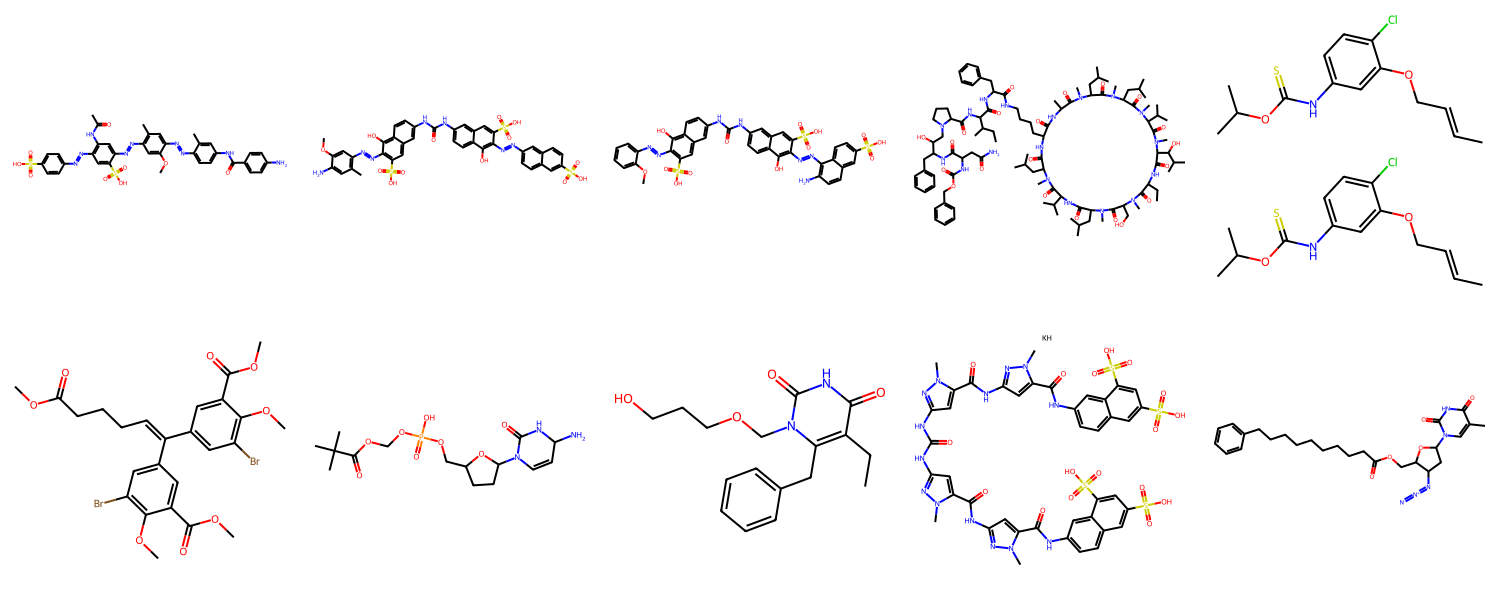

In [59]:
ca_samples = main_df[main_df['activity'] == 'CA'].sample(SAMPLE_COUNT, random_state=SEED)['smiles'].values
image_grid(get_mol_images(ca_samples), COL, ROW)

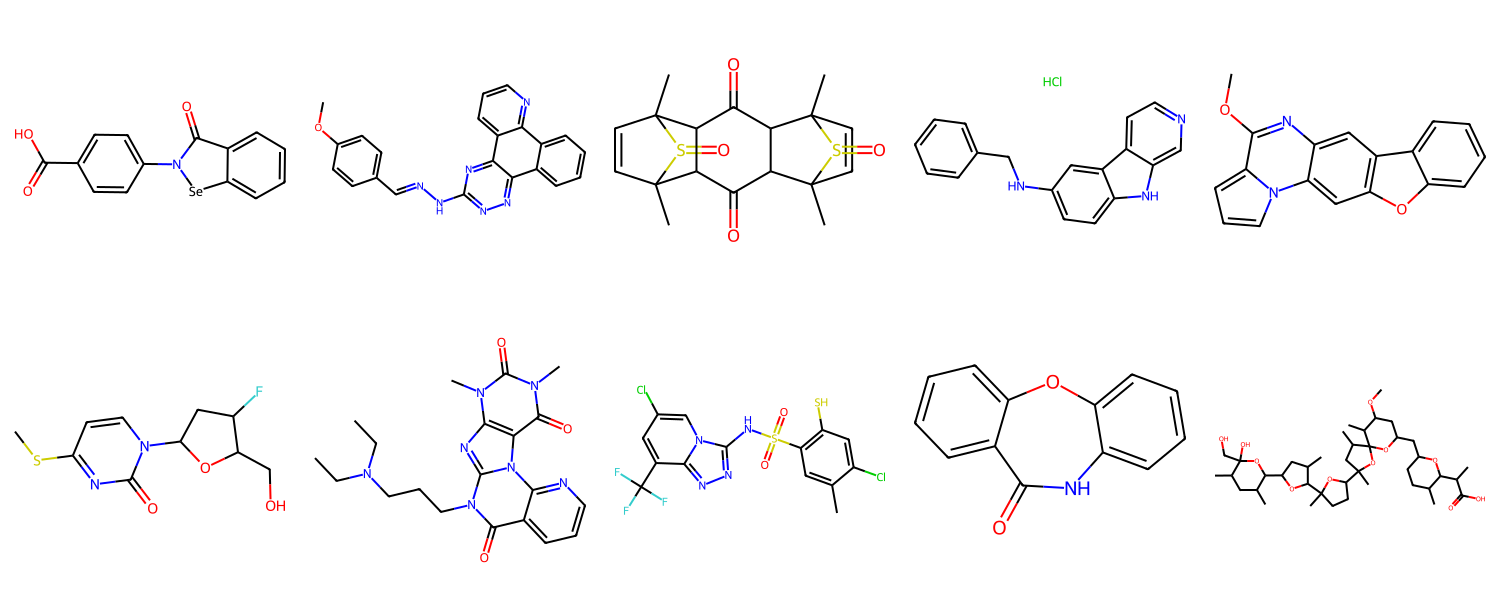

In [62]:
cm_samples = main_df[main_df['activity'] == 'CM'].sample(SAMPLE_COUNT, random_state=SEED)['smiles'].values
image_grid(get_mol_images(cm_samples), COL, ROW)